In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, 
                                     Dropout, LSTM, Reshape, BatchNormalization, Bidirectional, 
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Image Parameters
img_size = (224, 224)
batch_size = 32
train_dir = "./dataset/train"
test_dir = "./dataset/validation"

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)

num_classes = len(train_generator.class_indices)
labels = train_generator.classes
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(labels), y=labels)))

# Further fine-tuned class weights
class_weights[0] *= 1.65  # Slightly increase benign weight
class_weights[1] *= 1.3   # Keep malignant weight stable
class_weights[2] *= 1.10  # Reduce to improve precision

# Model Definition
def build_model(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)
    
    x = Bidirectional(LSTM(256, dropout=0.12, recurrent_dropout=0.08, return_sequences=True, kernel_regularizer=l2(1e-4)))(x)
    x = Bidirectional(LSTM(128, dropout=0.08, kernel_regularizer=l2(1e-4)))(x)
    
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.25)(x)  # Slightly reduced to retain more features
    output = Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs=input_layer, outputs=output)
    return model

# Compile Model with optimized learning rate
model = build_model((224, 224, 3), num_classes)
model.compile(optimizer=Adam(learning_rate=3e-5), loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=4, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
]

# Train Model
model.fit(train_generator, validation_data=test_generator, epochs=50, class_weight=class_weights, callbacks=callbacks)

# Fine-tuning phase
model.compile(optimizer=Adam(learning_rate=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_generator, validation_data=test_generator, epochs=10, class_weight=class_weights, callbacks=callbacks)

# Evaluate Model
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

model.save("final_model.h5")


Found 1578 images belonging to 3 classes.
Found 1578 images belonging to 3 classes.


C:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5159 - loss: 1.6397  

50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.5175 - loss: 1.6388 - val_accuracy: 0.1686 - val_loss: 1.3648 - learning_rate: 3.0000e-05
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.6669 - loss: 1.4334 - val_accuracy: 0.1686 - val_loss: 1.4393 - learning_rate: 3.0000e-05
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6774 - loss: 1.3096 - val_accuracy: 0.1686 - val_loss: 1.4430 - learning_rate: 3.0000e-05
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.6913 - loss: 1.2100 - val_accuracy: 0.1686 - val_loss: 1.3980 - learning_rate: 3.0000e-05
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6921 - loss: 1.1722    

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.6923 - loss: 1.1717 - val_accuracy: 0.3542 - val_loss: 1.3422 - learning_rate: 3.0000e-05
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7198 - loss: 1.0918  

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7194 - loss: 1.0921 - val_accuracy: 0.3606 - val_loss: 1.2844 - learning_rate: 3.0000e-05
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7511 - loss: 1.0236  

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7509 - loss: 1.0239 - val_accuracy: 0.3809 - val_loss: 1.2651 - learning_rate: 3.0000e-05
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7440 - loss: 0.9874  

50/50 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7439 - loss: 0.9879 - val_accuracy: 0.3986 - val_loss: 1.2161 - learning_rate: 3.0000e-05
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7564 - loss: 0.9787  

50/50 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.7567 - loss: 0.9785 - val_accuracy: 0.6293 - val_loss: 0.9709 - learning_rate: 3.0000e-05
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.7758 - loss: 0.9507 - val_accuracy: 0.5811 - val_loss: 0.9965 - learning_rate: 3.0000e-05
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.7989 - loss: 0.9160 - val_accuracy: 0.6109 - val_loss: 0.9945 - learning_rate: 3.0000e-05
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7772 - loss: 0.8900  

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7769 - loss: 0.8908 - val_accuracy: 0.7548 - val_loss: 0.7261 - learning_rate: 3.0000e-05
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7883 - loss: 0.9191  

50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.7885 - loss: 0.9187 - val_accuracy: 0.7269 - val_loss: 0.7171 - learning_rate: 3.0000e-05
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7781 - loss: 0.8874  

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7782 - loss: 0.8873 - val_accuracy: 0.8650 - val_loss: 0.5822 - learning_rate: 3.0000e-05
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8106 - loss: 0.8639 - val_accuracy: 0.8314 - val_loss: 0.5952 - learning_rate: 3.0000e-05
Epoch 16/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7894 - loss: 0.8749 - val_accuracy: 0.8251 - val_loss: 0.6351 - learning_rate: 3.0000e-05
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.7771 - loss: 0.8902 - val_accuracy: 0.8365 - val_loss: 0.6205 - learning_rate: 3.0000e-05
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8256 - loss: 0.7964  
Epoch 18: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8254 - loss: 0.7967 - val_accuracy: 0.6648 - val_loss: 1.0518 - learning_rate: 3.0000e-05
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8442 - loss: 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8245 - loss: 0.7522 - val_accuracy: 0.8485 - val_loss: 0.5635 - learning_rate: 9.0000e-06
Epoch 21/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8306 - loss: 0.7416 - val_accuracy: 0.7167 - val_loss: 0.9192 - learning_rate: 9.0000e-06
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8252 - loss: 0.7404 - val_accuracy: 0.7548 - val_loss: 0.7795 - learning_rate: 9.0000e-06
Epoch 23/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8334 - loss: 0.7311  

50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8335 - loss: 0.7313 - val_accuracy: 0.8485 - val_loss: 0.5563 - learning_rate: 9.0000e-06
Epoch 24/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8399 - loss: 0.7364 - val_accuracy: 0.8137 - val_loss: 0.6357 - learning_rate: 9.0000e-06
Epoch 25/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8349 - loss: 0.7589 - val_accuracy: 0.7250 - val_loss: 0.8571 - learning_rate: 9.0000e-06
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8449 - loss: 0.7159 - val_accuracy: 0.8029 - val_loss: 0.6614 - learning_rate: 9.0000e-06
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8191 - loss: 0.7840  
Epoch 27: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
50/50 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8191 - loss: 0.7836 - val_accuracy: 0.7839 - val_loss: 0.7400 - learning_rate: 9.0000e-06
Epoch 28/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.8471 - loss: 0

[[663 173  55]
 [ 25 386  10]
 [ 19   7 240]]
              precision    recall  f1-score   support

           0       0.94      0.74      0.83       891
           1       0.68      0.92      0.78       421
           2       0.79      0.90      0.84       266

    accuracy                           0.82      1578
   macro avg       0.80      0.85      0.82      1578
weighted avg       0.84      0.82      0.82      1578



50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step


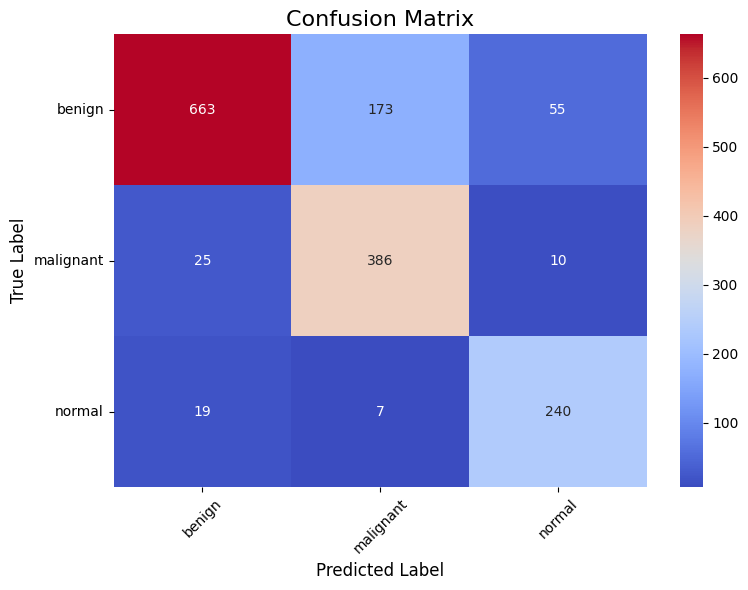

Classification Report:

              precision    recall  f1-score   support

      benign       0.94      0.74      0.83       891
   malignant       0.68      0.92      0.78       421
      normal       0.79      0.90      0.84       266

    accuracy                           0.82      1578
   macro avg       0.80      0.85      0.82      1578
weighted avg       0.84      0.82      0.82      1578



C:\Users\lenovo\AppData\Local\Temp\ipykernel_15588\102189657.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=f1_scores, palette='mako')


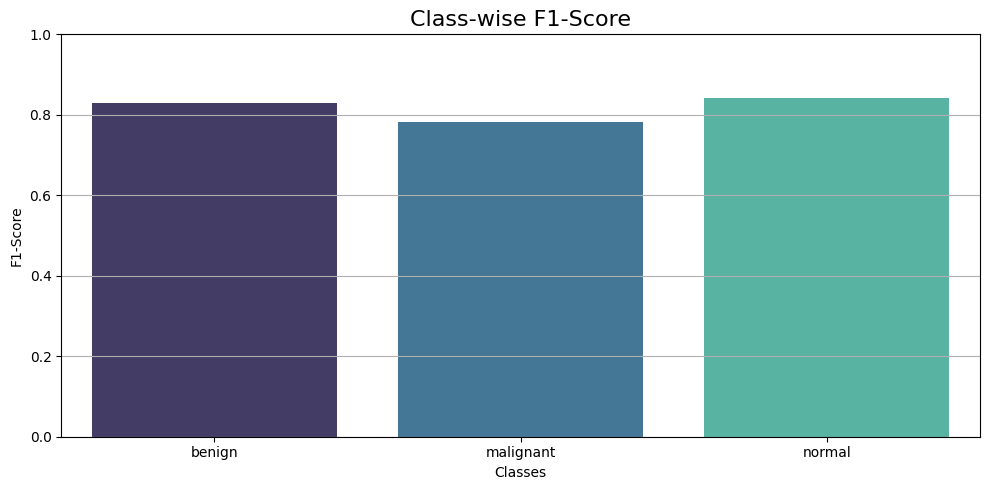

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the test generator (only if not already defined)
# Make sure this is already done before the below lines:
# test_generator = ...

# 1. Generate predictions and true labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Confusion Matrix - Colored Plot
cm = confusion_matrix(y_true, y_pred)
class_labels = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Classification Report (printed)
print("Classification Report:\n")
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
print(classification_report(y_true, y_pred, target_names=class_labels))

# 4. F1-score Bar Chart
f1_scores = [report[label]['f1-score'] for label in class_labels]

plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=f1_scores, palette='mako')
plt.title("Class-wise F1-Score", fontsize=16)
plt.xlabel("Classes")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
